# optimize path to link qubits in network

In [2]:
import networkx as nx 
import math
import pandas as pd
import matplotlib.pyplot as plt
G = nx.Graph()
G.add_edge(1,2)
G.add_edge(1,3)
G.add_edge(2,3)
G.add_edge(2,4)
G.add_edge(3,5)
G.add_edge(4,5)
G.add_edge(4,6)
G.add_edge(5,6)
#nx.draw(G, with_labels=True)
num_edges = nx.number_of_edges(G)
param_matrix = [[0]*(num_edges+1) for i in range(num_edges+1)]
#define with [distance (km), coupling eff. (%), num_qubits, attenuation length (km)]
param_matrix[1][2] = [30, 0.95, 20*5, 20]
param_matrix[1][3] = [30, 0.95, 30*5, 20]
param_matrix[2][3] = [30, 0.8, 30*5, 20]
param_matrix[2][4] = [20, 0.9, 20*5, 20]
param_matrix[3][5] = [20, 0.80, 20*5, 20]
param_matrix[4][5] = [30, 0.77, 15*5, 20]
param_matrix[4][6] = [20, 0.83,25*5, 20]
param_matrix[5][6] = [30, 0.99, 30*5, 20]
#We could print the list of all paths between two nodes (1,6) in the network using the simple function

# Entanglement generation (nodes)
We could start with entangled link generation between two nodes. 
Strategy: Try to create entangled pairs between "m" qubits. in case, none of them suceed, try again (try "neg" times). 
Probability of getting one pair (prob) = (1-(1-p)**(neg*m))
time taken = neg*dist/c (km/s in fiber)

In [3]:
def elink_edges(G, i,j, param):
    dist = param[i][j][0]
    latt = param[i][j][3]
    pc = (param[i][j][1])#coupling efficiency
    p = 0.5*(pc**2)* math.exp(-dist/latt)
    num_pairs = math.floor(param[i][j][2]/len(list(G.nodes()))-1) #number of pairs (edges) for one elink
    rate = 0
    prob_max = 0
    for neg in range(1,5):
        prob = (1-(1-p)**(neg*num_pairs)) #probability
        time = neg*dist/(2*1e5)
        if prob > prob_max:
            rate = prob*(1/time)
            qubits = num_pairs
            prob_max = prob
            time_comm = time
            neg_max = neg
    return rate, qubits, prob_max, time_comm, neg_max


def rate(links, elink):
    t_max = 0
    prob = 1
    qubits = 0
    for var in range(len(links)-1):
        if elink[links[var]][links[var+1]] ==0:
            prob= prob*elink[links[var+1]][links[var]][2]
        else:
            prob= prob*elink[links[var]][links[var+1]][2]
        
        if elink[links[var]][links[var+1]] ==0 and elink[links[var+1]][links[var]][3]> t_max:
            time =  elink[links[var+1]][links[var]][3]
            qubits = qubits + elink[links[var+1]][links[var]][1]
        elif elink[links[var]][links[var+1]][3]> t_max:
            time =  elink[links[var]][links[var+1]][3]
            qubits = qubits + elink[links[var]][links[var+1]][1]
    
    return qubits/(prob/time), qubits, time, prob


## Optimization with cost function
The optimized path is obtained by defining a cost function and find the path that yields the minimum cost

In [4]:
def cost_function(node_a, node_b, num_edges):
    paths = list(nx.all_simple_paths(G, node_a, node_b, cutoff=None))
    cost = [0]*(len(paths))
    qubits_tot = [0]*(len(paths))
    time = [0]*(len(paths))
    p_success = [0]*(len(paths))
    elink = [[0]*num_edges]*num_edges
    for a in range(len(paths)):
        for b in range(len(paths[a])-1):
            node_1 = paths[a][b]
            node_2 = paths[a][b+1]
            if node_1 > node_2:
                node_1 = node_2
                node_2 = paths[a][b]
            elink[node_1][node_2]= elink_edges(G, node_1,node_2, param_matrix) 
    for i in range(len(paths)):
        cost[i], qubits_tot[i], time[i],p_success[i] = rate(paths[i], elink)
    #print("The optimum path to nodes",node_a, "and", node_b, "based on the cost function is" ,paths[cost.index(min(cost))])
    return node_a, node_b, paths[cost.index(min(cost))], qubits_tot[cost.index(min(cost))], time[cost.index(min(cost))], p_success[cost.index(min(cost))]
    

In [5]:
nodes = list(G.nodes())
output = []
for i in range(0, len(nodes)):
    for j in range(i+1,len(nodes)):
        node_a, node_b, path, qubits, time, psuccess = cost_function(nodes[i], nodes[j], num_edges)
        output.append([node_a, node_b, path, qubits, time, psuccess])
df = pd.DataFrame(output, columns=['Node_1', 'Node_2', 'optimized path', 'qubits', 'time(s)', 'P_success'])
df

,Node_1,Node_2,optimized path,qubits,time(s),P_success
0,1,2,"[1, 2]",15,0.0006,0.998284
1,1,3,"[1, 3]",24,0.0006,0.999962
2,1,4,"[1, 2, 4]",30,0.0004,0.998221
3,1,5,"[1, 3, 5]",39,0.0004,0.999417
4,1,6,"[1, 2, 4, 6]",54,0.0006,0.998206
5,2,3,"[2, 3]",24,0.0006,0.999184
6,2,4,"[2, 4]",15,0.0004,0.999937
7,2,5,"[2, 4, 5]",26,0.0006,0.950708
8,2,6,"[2, 4, 6]",34,0.0004,0.999904
9,3,4,"[3, 5, 4]",30,0.0004,0.999393


#  Cost function for distributed quantum gate

Text(0.5, 1.0, 'number of trails required to achieve (1-P_success)<1e-3')

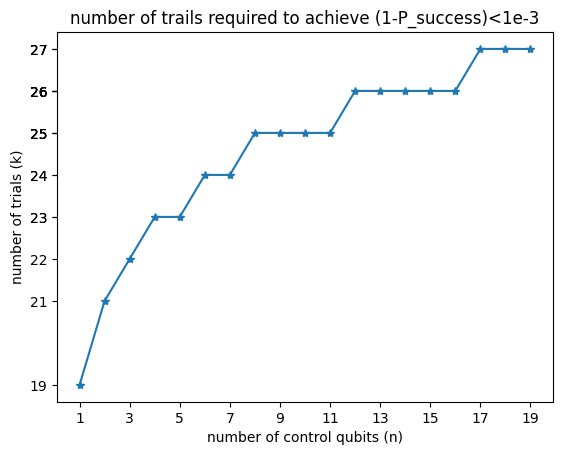

In [59]:
dist = 0.5
latt = 20
c = 2*1e5
pc = 0.8
p = 0.5*(pc**2)* math.exp(-dist/latt)
t_meas = 1e-7
t_cnot = 1e-7
t_local = 1e-8
cost = [0]*20
n_ctrl = [0]*20
x_ax = [0]*20
for n in range(1,20):
    p_all = [0]*100 
    for k in range(1,100):
        p_all[k] = ((1-(1-p)**k))**n
        if 1-p_all[k] < 1e-3:
            n_ctrl[n] = k
            cost[n] = 2*n*((k*((dist)/c)) + 2*(t_meas+(dist/c))+(t_cnot) + ((20*n-38)*t_cnot) + t_local)
            x_ax[n] = n
            break
plt.plot(x_ax[1:20],n_ctrl[1:20], '*-')
plt.xticks(x_ax[1:20:2])
plt.yticks(n_ctrl[1:20])
plt.xlabel("number of control qubits (n)")
plt.ylabel("number of trials (k)")
plt.title("number of trails required to achieve (1-P_success)<1e-3")

Text(0.5, 1.0, 'cost function for distributed quantum gate')

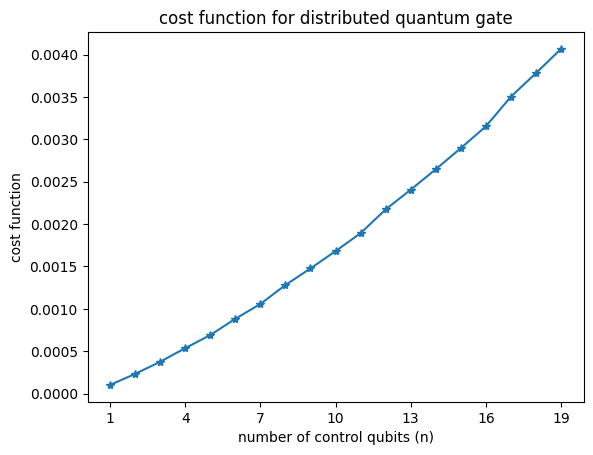

In [60]:
plt.plot(x_ax[1:20],cost[1:20], '*-')
plt.xticks(x_ax[1:20:3])
plt.xlabel("number of control qubits (n)")
plt.ylabel("cost function")
plt.title("cost function for distributed quantum gate")

#  Cost function (quantum circuit) = number of gates* cost function (gate)

In [51]:
#phase estimation with n_phase qubits and single target qubit. There are n_phase controlled unitary gates
#between the control qubits and the target
dist = 10
latt = 20
c = 2*1e5
pc = 0.8
p = 0.5*(pc**2)* math.exp(-dist/latt)
t_meas = 1e-7
t_cnot = 1e-7
t_local = 1e-8
cost = [0]*20
n_ctrl = [0]*20
x_ax = [0]*20
n = 2
n_phase = 3
p_all = [0]*100 
for k in range(1,100):
    p_all[k] = ((1-(1-p)**k))**n
    if 1-p_all[k] < 1e-3:
        n_ctrl = k
        cost_1= n_phase*2*n*((k*((dist)/c)) + 2*(t_meas+(dist/c))+(t_cnot) + ((2)*t_cnot) + t_local)
        cost_2= n_phase**3*(3*((k*((dist)/c)) + 2*(t_meas+(dist/c))+(t_cnot) + ((2)*t_cnot) + t_local)+(2)*t_cnot+4*dist/c)
        x_ax = n
        break
print("The cost function for the phase estimation algorithm")
print("scheme 1: number of qubits/node = 1, (qubits 1,2,3 in different nodes), cost is {}".format(cost_2))
print("scheme 2: number of qubits/node = 2, (qubits, 1,2 in the same node, 3 in different node) cost is {}".format(cost_1                                                                                                              ))
print("Number of trails for success probability close to 1, is",k)

The cost function for the phase estimation algorithm
scheme 1: number of qubits/node = 1, (qubits 1,2,3 in different nodes), cost is 0.15934670999999997
scheme 2: number of qubits/node = 2, (qubits, 1,2 in the same node, 3 in different node) cost is 0.02280612
Number of trails for success probability close to 1, is 36


References:
    1) https://arxiv.org/abs/quant-ph/0005101
    2) https://www.nature.com/articles/s41586-018-0470-y